# Previsão do preço de venda de diamantes usando aprendizado de máquina


Neste notebook, vamos passar por um exemplo de projeto de Machine Learning com o objetivo de prever o preço de venda de diamantes.

## 1. Definição do problema

* Quão bem podemos prever o preço de venda futuro de um diamante, dadas suas características e exemplos anteriores de diamantes semelhantes que foram vendidos?

## 2. Dados

Os dados são baixados do Kaggle: https://www.kaggle.com/code/manishwahale/diamond-price-prediction/notebook


## 3. Avaliação

A métrica de avaliação para este projeto é o RMSLE (root mean squared log error) entre os preços reais e previstos do leilão.


## 4. Características

Existem 53.940 diamantes no conjunto de dados com 10 recursos (quilate, corte, cor, clareza, profundidade, tabela, preço, x, y e z). A maioria das variáveis ​​são de natureza numérica, mas as variáveis ​​corte, cor e clareza são variáveis ​​de fator ordenadas com os seguintes níveis.

Sobre a moeda da coluna de preço: é Preço ($)

E sobre as colunas x,yez são medidas de diamante como (( x: comprimento em mm, y: largura em mm,z: profundidade em mm )).

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [5]:
# Importando o dataset
df = pd.read_csv("diamonds.csv",
                 low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53943 entries, 0 to 53942
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53943 non-null  int64  
 1   carat       53943 non-null  float64
 2   cut         53943 non-null  object 
 3   color       53943 non-null  object 
 4   clarity     53943 non-null  object 
 5   depth       53943 non-null  float64
 6   table       53943 non-null  float64
 7   price       53943 non-null  int64  
 8   x           53943 non-null  float64
 9   y           53943 non-null  float64
 10  z           53943 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [6]:
df.isna().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

In [7]:
df.columns

Index(['Unnamed: 0', 'carat', 'cut', 'color', 'clarity', 'depth', 'table',
       'price', 'x', 'y', 'z'],
      dtype='object')

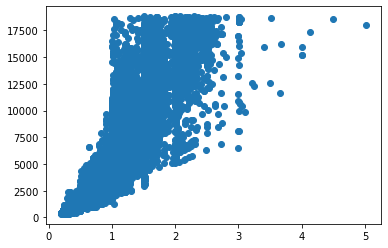

In [22]:
fig, ax = plt.subplots()
ax.scatter(df["carat"][:100000], df["price"][:100000])

In [26]:
df.carat[:10000]

0       0.23
1       0.21
2       0.23
3       0.29
4       0.31
        ... 
9995    1.00
9996    1.00
9997    1.00
9998    1.00
9999    1.00
Name: carat, Length: 10000, dtype: float64

In [27]:

df.carat.dtype

dtype('float64')

<AxesSubplot:ylabel='Frequency'>

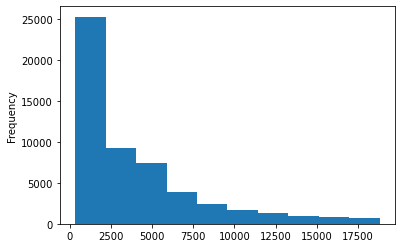

In [28]:
df.price.plot.hist()

In [29]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [31]:
df.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000
mean,26972.000000,0.797935,61.749322,57.457251,3932.734294,5.731158,5.734526,3.538730
std,15572.147122,0.473999,1.432626,2.234549,3989.338447,1.121730,1.142103,0.705679
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13486.500000,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26972.000000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40457.500000,1.040000,62.500000,59.000000,5324.000000,6.540000,6.540000,4.040000
max,53943.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Separando variáveis Numéricas e Categóricas

In [32]:
num_cols = df.select_dtypes('number')
cat_cols = df.select_dtypes('O')
for c in cat_cols.columns:
    print(cat_cols[c].unique())


['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
['E' 'I' 'J' 'H' 'F' 'G' 'D']
['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


Visualizando a distribuição de variáveis categóricas

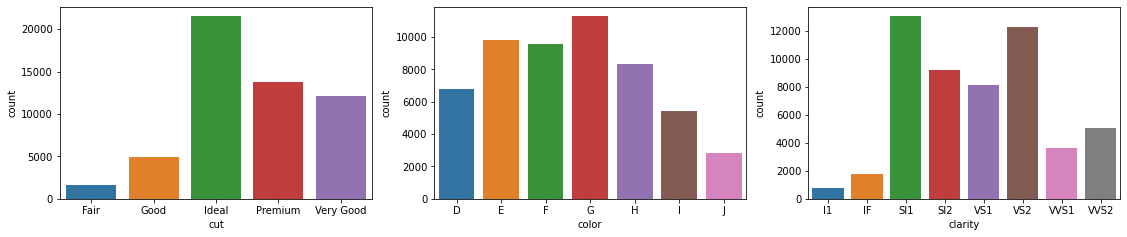

In [36]:
i = 1
plt.figure(figsize=(19, 12))
for c in cat_cols.columns:
    plt.subplot(3, 3, i)
    sns.countplot(x=df[c].sort_values())
    i+=1

Lidando com outliers

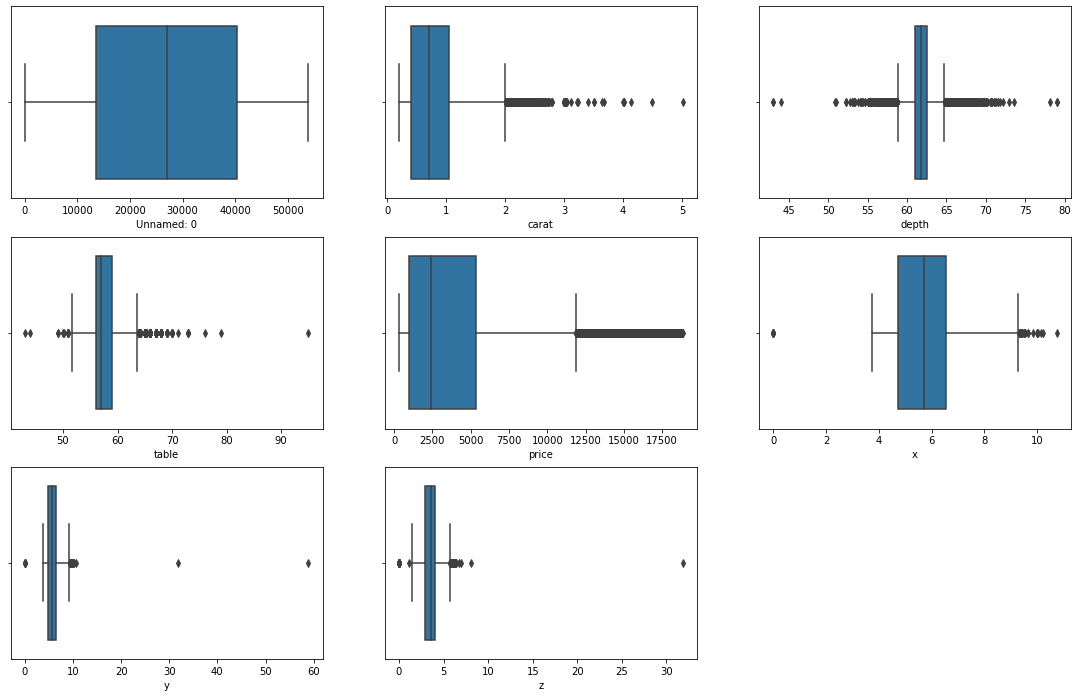

In [38]:
i = 1
plt.figure(figsize=(19, 12))
for c in num_cols.columns:
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[c])
    i+=1


Usamos o valor-Z para detectar outiliers. Ele mede e o quão distante das medidas de tendência central este valor está. Vamos considerar neste modelo os valore que possuem -3 < Z > 3.

In [39]:
df = df[(np.abs(stats.zscore(num_cols)) < 3).all(axis=1)]

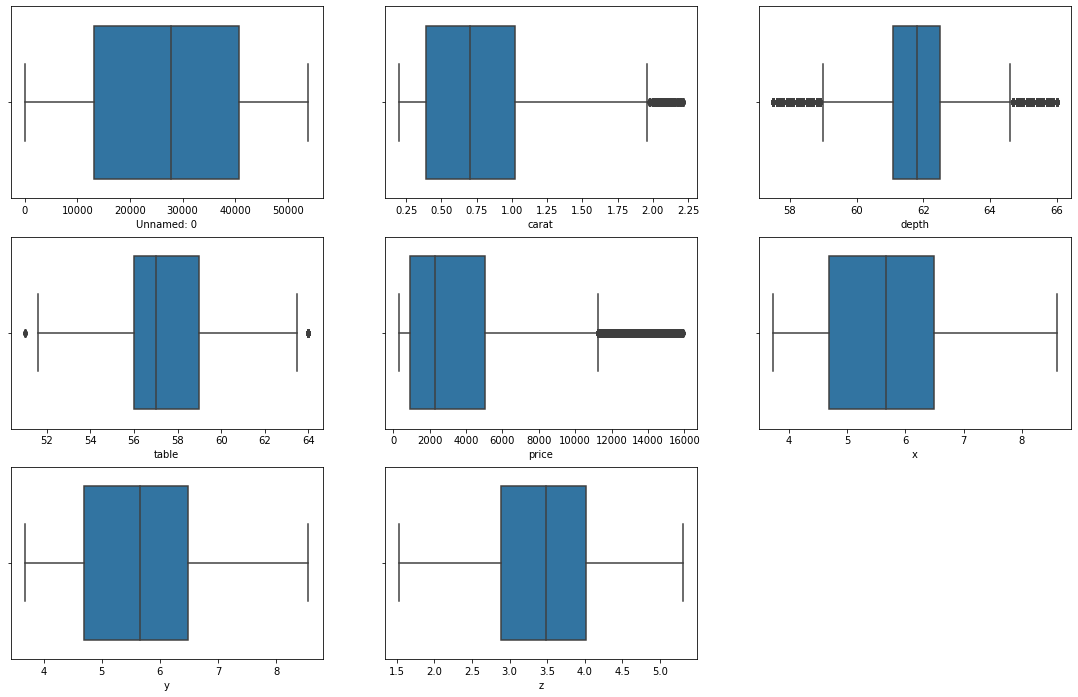

In [40]:
num_cols = df.select_dtypes('number')
i = 1
plt.figure(figsize=(19, 12))
for c in num_cols.columns:
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[c])
    i+=1

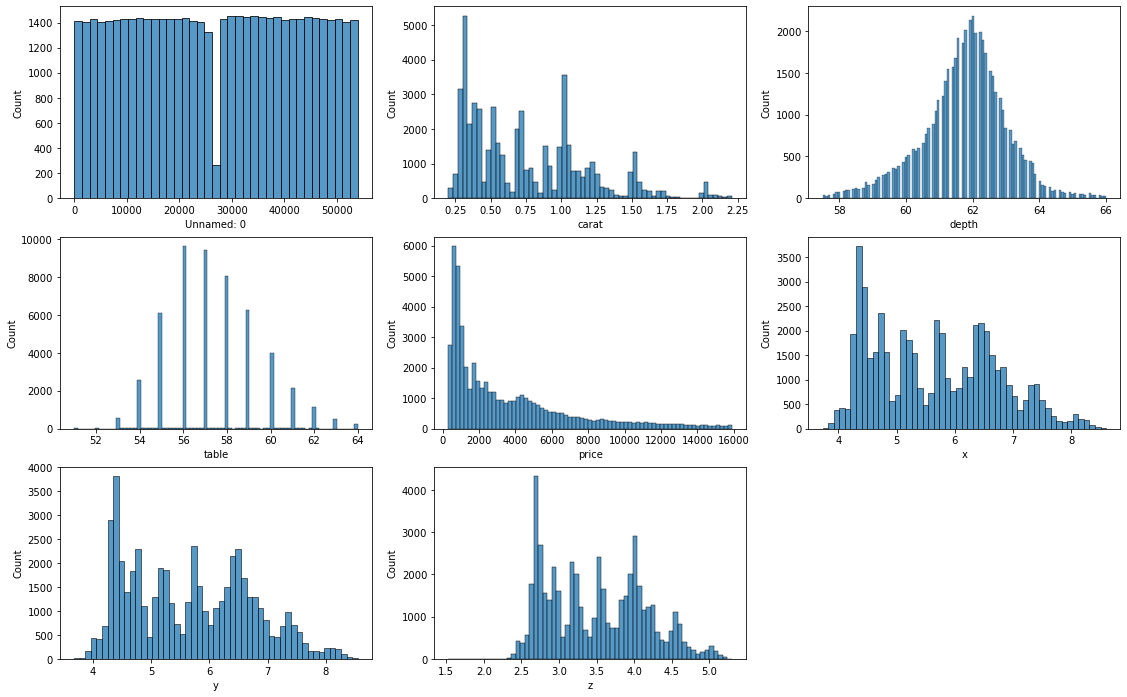

In [41]:
# Distribuição das variáveis numéricas
num_cols = df.select_dtypes('number')
i = 1
plt.figure(figsize=(19, 12))
for c in num_cols.columns:
    plt.subplot(3, 3, i)
    sns.histplot(x = df[c])
    i+=1

## Modelagem

### Converter variáveis categóricas em numéricas

Uma maneira de transformar todos os nossos dados em números é convertê-los em pandas categories.


In [43]:
df.head().T

,0,1,3,4,5
Unnamed: 0,1,2,4,5,6
carat,0.23,0.21,0.29,0.31,0.24
cut,Ideal,Premium,Premium,Good,Very Good
color,E,E,I,J,J
clarity,SI2,SI1,VS2,SI2,VVS2
depth,61.5,59.8,62.4,63.3,62.8
table,55.0,61.0,58.0,58.0,57.0
price,326,326,334,335,336
x,3.95,3.89,4.2,4.34,3.94
y,3.98,3.84,4.23,4.35,3.96


In [44]:
pd.api.types.is_string_dtype(df["cut"])

True

In [46]:
pd.api.types.is_string_dtype(df["color"])

True

In [45]:
pd.api.types.is_string_dtype(df["clarity"])

True

In [48]:
# Encontrar as colunas que contêm strings
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

cut
color
clarity


In [49]:
# Isso transformará todos os valores string em números
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        df[label] = content.astype("category").cat.as_ordered()

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51593 entries, 0 to 53942
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Unnamed: 0  51593 non-null  int64   
 1   carat       51593 non-null  float64 
 2   cut         51593 non-null  category
 3   color       51593 non-null  category
 4   clarity     51593 non-null  category
 5   depth       51593 non-null  float64 
 6   table       51593 non-null  float64 
 7   price       51593 non-null  int64   
 8   x           51593 non-null  float64 
 9   y           51593 non-null  float64 
 10  z           51593 non-null  float64 
dtypes: category(3), float64(6), int64(2)
memory usage: 5.7 MB


In [52]:
df.cut.cat.categories

Index(['Fair', 'Good', 'Ideal', 'Premium', 'Very Good'], dtype='object')

In [54]:
df.color.cat.categories

Index(['D', 'E', 'F', 'G', 'H', 'I', 'J'], dtype='object')

In [55]:
df.clarity.cat.categories

Index(['I1', 'IF', 'SI1', 'SI2', 'VS1', 'VS2', 'VVS1', 'VVS2'], dtype='object')

Agora temos uma maneira de acessar todos os nossos dados na forma de números.

In [56]:
df.cut.cat.codes

0        2
1        3
3        3
4        1
5        4
        ..
53938    3
53939    2
53940    3
53941    3
53942    4
Length: 51593, dtype: int8

In [58]:
# Verifica dados ausentes
df.isnull().sum()/len(df)

Unnamed: 0    0.0
carat         0.0
cut           0.0
color         0.0
clarity       0.0
depth         0.0
table         0.0
price         0.0
x             0.0
y             0.0
z             0.0
dtype: float64

In [59]:
df.isna().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

## Preenchendo e transformando variáveis categóricas em números

In [61]:
# Verifique se há colunas que não são numéricas
for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

cut
color
clarity


In [62]:
# Transforme variáveis categóricas em números e preencha as lacunas
for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        df[label+"_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add +1
        df[label] = pd.Categorical(content).codes+1

In [63]:
pd.Categorical(df["cut"]).codes+1

array([3, 4, 4, ..., 4, 4, 5], dtype=int8)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51593 entries, 0 to 53942
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          51593 non-null  int64  
 1   carat               51593 non-null  float64
 2   cut                 51593 non-null  int8   
 3   color               51593 non-null  int8   
 4   clarity             51593 non-null  int8   
 5   depth               51593 non-null  float64
 6   table               51593 non-null  float64
 7   price               51593 non-null  int64  
 8   x                   51593 non-null  float64
 9   y                   51593 non-null  float64
 10  z                   51593 non-null  float64
 11  cut_is_missing      51593 non-null  bool   
 12  color_is_missing    51593 non-null  bool   
 13  clarity_is_missing  51593 non-null  bool   
dtypes: bool(3), float64(6), int64(2), int8(3)
memory usage: 5.9 MB


In [65]:
# Agora todas as variáveis são numéricas
df.head().T

,0,1,3,4,5
Unnamed: 0,1,2,4,5,6
carat,0.23,0.21,0.29,0.31,0.24
cut,3,4,4,2,5
color,2,2,6,7,7
clarity,4,3,6,4,8
depth,61.5,59.8,62.4,63.3,62.8
table,55.0,61.0,58.0,58.0,57.0
price,326,326,334,335,336
x,3.95,3.89,4.2,4.34,3.94
y,3.98,3.84,4.23,4.35,3.96


In [66]:
df.isna().sum()

Unnamed: 0            0
carat                 0
cut                   0
color                 0
clarity               0
depth                 0
table                 0
price                 0
x                     0
y                     0
z                     0
cut_is_missing        0
color_is_missing      0
clarity_is_missing    0
dtype: int64

In [67]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z,cut_is_missing,color_is_missing,clarity_is_missing
0,1,0.23,3,2,4,61.5,55.0,326,3.95,3.98,2.43,False,False,False
1,2,0.21,4,2,3,59.8,61.0,326,3.89,3.84,2.31,False,False,False
3,4,0.29,4,6,6,62.4,58.0,334,4.20,4.23,2.63,False,False,False
4,5,0.31,2,7,4,63.3,58.0,335,4.34,4.35,2.75,False,False,False
5,6,0.24,5,7,8,62.8,57.0,336,3.94,3.96,2.48,False,False,False


In [68]:
len(df)

51593

In [115]:
df.drop(columns=['cut_is_missing', 'color_is_missing', "clarity_is_missing"], axis=1, inplace=True)
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,3,2,4,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,4,2,3,59.8,61.0,326,3.89,3.84,2.31
3,4,0.29,4,6,6,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,2,7,4,63.3,58.0,335,4.34,4.35,2.75
5,6,0.24,5,7,8,62.8,57.0,336,3.94,3.96,2.48


### Correlation Matrix

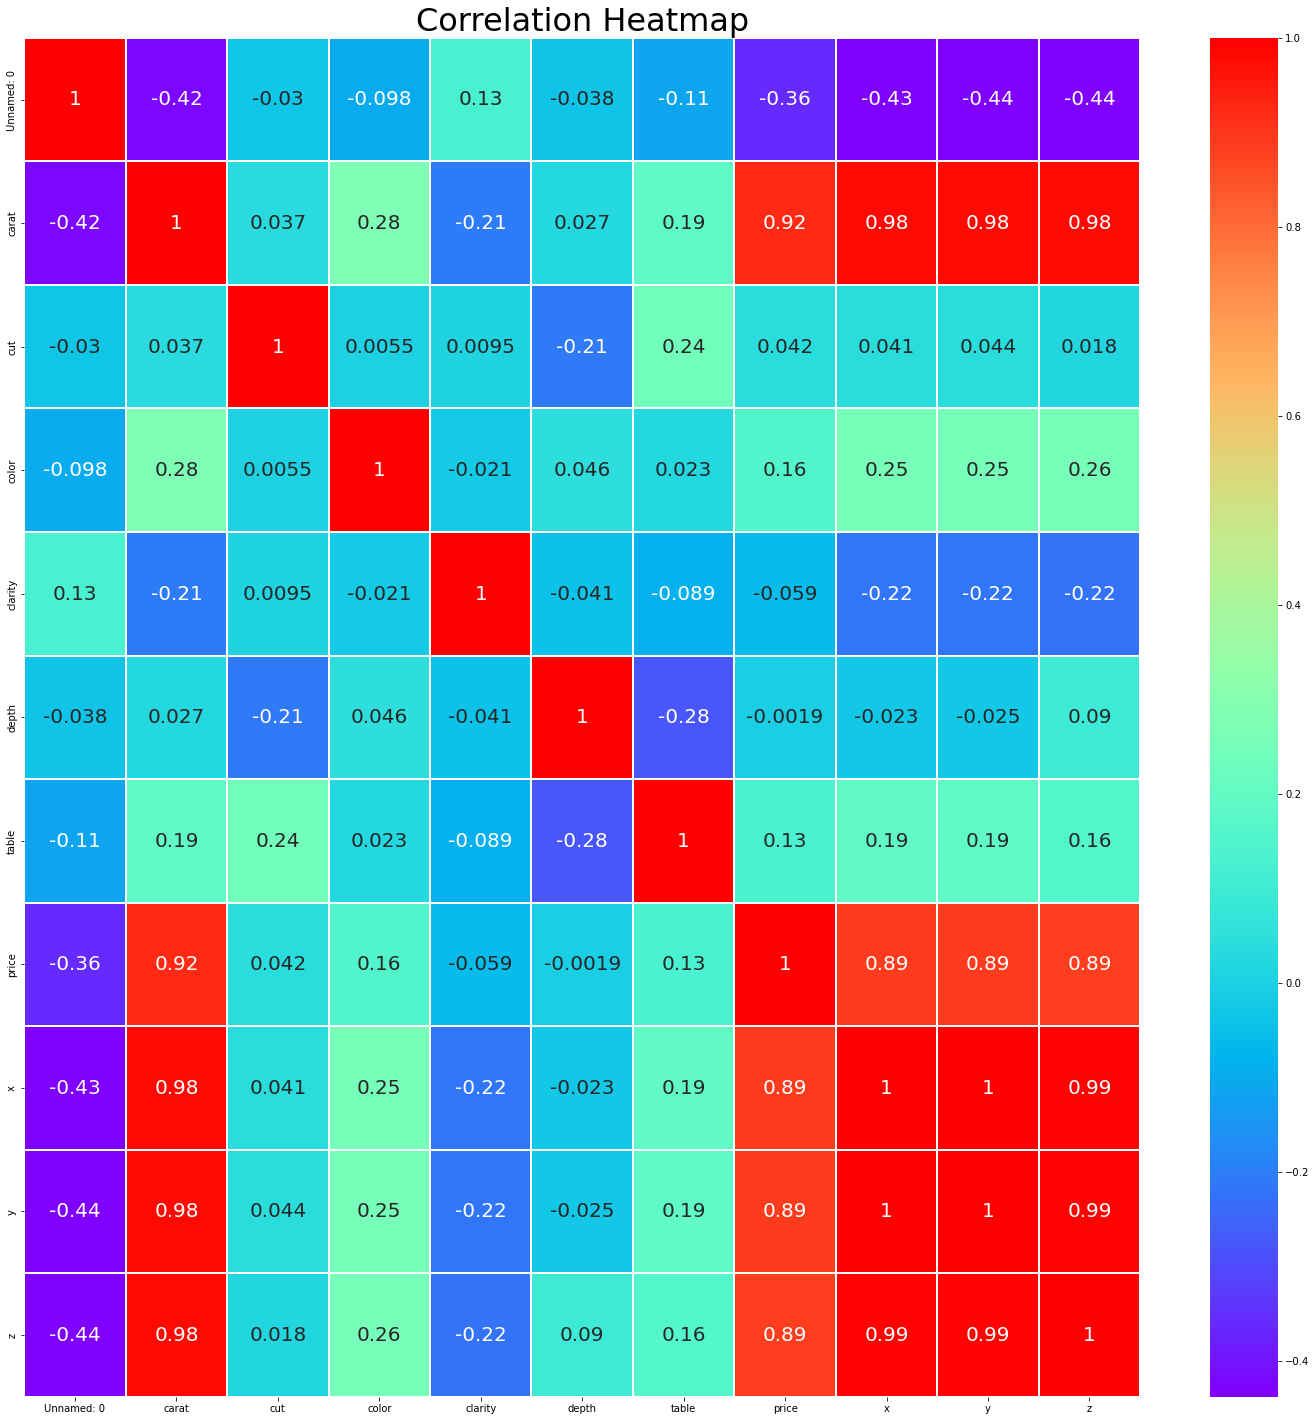

In [116]:
plt.figure(figsize=(25,25));
sns.heatmap(df.corr(),annot=True,cmap='rainbow',linewidth=0.01, annot_kws={'size': 20});
plt.title('Correlation Heatmap',fontsize=32,fontweight=5);

In [118]:
%%time
# Instanciar o modelo
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)

# Fit do modelo
model.fit(df.drop("price", axis=1), df["price"])

CPU times: user 17.5 s, sys: 99.3 ms, total: 17.6 s
Wall time: 2.4 s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [119]:
# Avaliar o modelo
model.score(df.drop("price", axis=1), df["price"])

0.999992831182738

A métrica acima não "retém água", por isso vamos dividir dados em conjuntos de treinamento/validação:

In [120]:
# Definir X e Y

X = df.drop("price", axis=1)

# Target variable
y = df.price.values

In [121]:
#Random seed para reprodutibilidade
np.random.seed(42)

# Dividir dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, # variáveis independentes 
                                                    y, # variável dependente
                                                    test_size = 0.2)

In [122]:
y_train

array([4862, 1013, 1715, ..., 1122, 2874, 6470])

## Construindo uma função de avaliação

In [123]:
# Criar função de avaliação (RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    Calcula o erro de log quadrático médio da raiz entre as previsões e
    rótulos verdadeiros.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Criar função para avaliar o modelo em alguns níveis diferentes
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_test)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_test, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_test, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_test, val_preds)}
    return scores

#### Testando nosso modelo em um subconjunto (para ajustar os hiperparâmetros)

In [124]:
# Alterar valor max_samples
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=10000)

In [125]:
%%time
# Reduzir o número máximo de amostras que cada estimador pode ver melhora o tempo de treinamento
model.fit(X_train, y_train)

CPU times: user 4.6 s, sys: 48 ms, total: 4.65 s
Wall time: 691 ms


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [126]:
(X_train.shape[0] * 100) / 1000000

4.1274

In [127]:
10000 * 100

1000000

In [128]:
show_scores(model)

{'Training MAE': 4.844483209768864,
 'Valid MAE': 6.00922279290629,
 'Training RMSLE': 0.03358644655881319,
 'Valid RMSLE': 0.04133339252549746,
 'Training R^2': 0.9999153430239125,
 'Valid R^2': 0.9998496020314831}

### Ajuste de hiperparâmetros com RandomizedSearchCV

In [129]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Diferentes hiperparâmetros RandomForestRegressor
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

# Instanciar o modelo RandomizedSearchCV
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=2,
                              cv=5,
                              verbose=True)

# Ajustar o modelo RandomizedSearchCV
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: user 1.12 s, sys: 194 ms, total: 1.31 s
Wall time: 3.25 s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [130]:
# Encontre os melhores hiperparâmetros do modelo
rs_model.best_params_

{'n_estimators': 40,
 'min_samples_split': 8,
 'min_samples_leaf': 13,
 'max_samples': 10000,
 'max_features': 'sqrt',
 'max_depth': 10}

In [131]:
# Avalie o modelo RandomizedSearch
show_scores(rs_model)

{'Training MAE': 126.79258130011299,
 'Valid MAE': 130.5129968385741,
 'Training RMSLE': 0.09457200408959558,
 'Valid RMSLE': 0.09589077161847046,
 'Training R^2': 0.9923419382528863,
 'Valid R^2': 0.9919351548464856}

Treine um modelo com os melhores hiperparâmetros
Nota: Estes foram encontrados após 100 iterações de RandomizedSearchCV.

In [132]:
%%time

# Hiperparâmetros mais ideais
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42) # random state so our results are reproducible

# Encaixe o modelo ideal
ideal_model.fit(X_train, y_train)

CPU times: user 2.82 s, sys: 18.2 ms, total: 2.84 s
Wall time: 426 ms


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [133]:
# Pontuações para ideal_model (treinado em todos os dados)
show_scores(ideal_model)

{'Training MAE': 13.43496266471007,
 'Valid MAE': 18.785959294474313,
 'Training RMSLE': 0.023198765868149628,
 'Valid RMSLE': 0.03586556527519267,
 'Training R^2': 0.9998477672807389,
 'Valid R^2': 0.9995742719842999}

In [134]:
# Pontuações em rs_model (treinado apenas em ~ 10.000 exemplos)
show_scores(rs_model)

{'Training MAE': 126.79258130011299,
 'Valid MAE': 130.51299683857414,
 'Training RMSLE': 0.09457200408959558,
 'Valid RMSLE': 0.09589077161847046,
 'Training R^2': 0.9923419382528863,
 'Valid R^2': 0.9919351548464856}

### Faça previsões sobre dados de teste

In [135]:
test_preds = ideal_model.predict(X_test)

In [136]:
test_preds

array([1908.0653533 , 1436.10637907, 3894.90950261, ...,  521.24220354,
       2069.76958259, 9454.37408381])

In [139]:
# Formate as previsões no mesmo formato aceito pelo Kaggle 
df_preds = pd.DataFrame()
df_preds["SalesPrice"] = test_preds
df_preds

,SalesPrice
0,1908.065353
1,1436.106379
2,3894.909503
3,1781.958124
4,3165.629152
...,...
10314,581.557294
10315,3656.833256
10316,521.242204
10317,2069.769583


## Importância das variáveis

Quais diferentes atributos dos dados foram mais importantes quando se trata de prever a variável de destino (price)?

In [140]:
# Encontre a importância do recurso do nosso melhor modelo
ideal_model.feature_importances_

array([2.13878838e-01, 4.21994094e-01, 5.36430117e-05, 2.54818429e-03,
       1.29454821e-02, 1.39763601e-04, 7.09936881e-05, 8.06435370e-02,
       1.92143167e-01, 7.55822968e-02])

In [141]:
# Função auxiliar para plotar a importância da variável
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot do dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

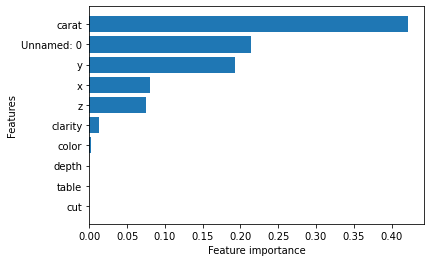

In [142]:
plot_features(X_train.columns, ideal_model.feature_importances_)

In [144]:
import pickle

# Salvar o modelo como arquivo 
pickle.dump(rs_model, open("diamond-price-prediction.pkl", "wb"))